<a href="https://colab.research.google.com/github/iambrookedrake/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Brooke_Drake_DSPT6_U2S1M4_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
Open= 'Date', 'Cost', 'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume'
Categ='Burrito','Yelp', 'Google',  'Hunger','Tortilla','Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap'
Closed= 'Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini'

In [0]:
##Deal with NaNs of Different types
import numpy as np
df = df.replace({'x':'y','X':'y','yes':'y','Yes':'y','no':'n','No':'n'})
#for i in Open:
 # df[i] = df[i].replace(np.NaN,'?')
#for i in Categ:
  #df[i] = df[i].replace(np.NaN,'?')
for i in Closed:
  df[i] = df[i].replace(np.NaN,'n')

In [0]:
df.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
count,87.000000,87.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000
mean,3.887356,4.167816,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904
std,0.475396,0.373698,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000
50%,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000
75%,4.000000,4.400000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [0]:
df.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421
unique,5,169,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2
top,California,8/30/2016,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,False
freq,169,29,396,388,414,242,263,267,262,294,329,370,400,400,415,385,386,410,414,414,420,413,383,414,406,404,417,414,419,417,417,420,421,416,418,418,419,408,418,420,239


In [0]:
##Do train/validate/test split. Train on reviews from 2016 & earlier. 
##Validate on 2017. Test on 2018 & later.
import datetime
from datetime import datetime, date, time
df['year'] = df['Date']
df['year'] = pd.to_datetime(df['year'], infer_datetime_format=True)
df['year']=df['year'].dt.year
train = df[df['year'] < 2017]
val = df[df['year'] == 2017]
test = df[df['year'] > 2017]
print( train.shape, val.shape, test.shape)

(298, 60) (85, 60) (38, 60)


In [0]:
## Begin with baselines for classification.
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)
majority_class = y_train.mode()[0]
y_train_pred = [majority_class]*len(y_train)

from sklearn.metrics import accuracy_score, mean_absolute_error

print(f'Baseline accuracy: {accuracy_score(y_train, y_train_pred)}')

Baseline accuracy: 0.5906040268456376


In [0]:
##Use scikit-learn for logistic regression.
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs')

features = ['Cost', 'Length',  'Circum']
X_train = train[features]
X_val = val[features]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

log_reg.fit(X_train_imputed, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

y_val = val[target]
y_pred = [majority_class]*len(val)

y_pred = log_reg.predict(X_val_imputed)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')
y_pred

Validation accuracy: 0.5529411764705883


array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True, False,  True,  True, False,  True, False,
       False, False, False,  True, False, False,  True,  True, False,
       False,  True, False, False])

In [0]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)

imputer = SimpleImputer()
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_enc.columns)
X_train_sc.head()

,Cost,Length,Circum
0,-0.339805,0.0,0.0
1,-1.208571,0.0,0.0
2,-1.709783,0.0,0.0
3,-1.375642,0.0,0.0
4,-0.256270,0.0,0.0


In [0]:
##Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
from sklearn.linear_model import LogisticRegression
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_val_sc)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.5529411764705883


In [0]:
##Get your model's test accuracy. (One time, at the end.)

In [0]:
test_case = [[8,22,23]]  # $8 Burrito, 22cm long 23cm circumference (upper 75%ile)
log_reg.predict(test_case)

array([ True])

In [0]:
print(log_reg.predict(test_case))
print(log_reg.predict_proba(test_case))
print(log_reg.coef_)
print(log_reg.intercept_)

[ True]
[[0.49109357 0.50890643]]
[[0.24121425 0.05820616 0.01740458]]
[-3.57492528]


In [0]:
def sigmoid(x):
    return 1 / (1 + np.e**(-x))

print(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

[[0.03562949]]


array([[0.50890643]])

In [0]:
##Stretch: Get and plot your coefficients.
coefs = model.coef_[0]
coefs = pd.Series(coefs, X_train_sc.columns)
coefs

Cost      0.002045
Length    0.000507
Circum    0.000740
dtype: float64

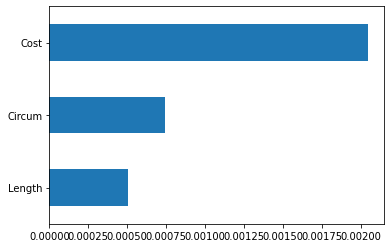

In [0]:
coefs.sort_values().plot.barh()